<a href="https://colab.research.google.com/github/s4hlo/notebooks/blob/main/Lab3_Introdu%C3%A7%C3%A3o_a_Classifica%C3%A7%C3%A3o_de_Texto_utilizando_TF_IDF_e_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - Carregando e preprocessando os dados

In [ ]:
import gdown
import json # Importa a biblioteca json

google_drive_link = 'https://drive.google.com/uc?id=1QtLT6pXyOcMVGjMFjDaY8zc2w2cFWzGT'
output_filename = 'dados_confusão.txt' # O nome do arquivo de saída, mesmo que seja json, a extensão .txt não impede a leitura como json

gdown.download(google_drive_link, output_filename, quiet=False)

# Agora você pode ler o arquivo baixado como JSON
with open(output_filename, 'r') as f:
    dados_json = json.load(f) # Usa json.load() para carregar o conteúdo como um objeto JSON

print('\nDados carregados:')
print([(i['intent'], len(i['examples'])) for i in dados_json])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Inicializar listas vazias para armazenar os dados
texts = []
intents = []

# Iterar sobre cada dicionário na lista dados_json
for entry in dados_json:
    intent = entry['intent'] # Obter o valor da chave 'intent'
    examples = entry['examples'] # Obter a lista de exemplos

    # Iterar sobre cada exemplo e adicionar à lista de textos e intentos correspondentes
    for example in examples:
        texts.append(example)
        intents.append(intent)

# Criar um DataFrame do pandas com as listas coletadas
df = pd.DataFrame({'text': texts, 'intent': intents})

# Exibir as primeiras linhas do DataFrame para verificar o resultado
display(df.sample(10))

In [ ]:
# Separar os dados em treino e teste usando amostragem estratificada
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['intent'],
                                                    test_size=0.20,
                                                    random_state=42)

print("\nDistribuição das classes no conjunto de treino:")
display(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
display(y_test.value_counts())

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# One-Hot Encoding nos labels
# Como a variável target já é uma série, precisamos remodela-la para o OneHotEncoder
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Inicializar o OneHotEncoder
# handle_unknown='ignore' é útil caso apareçam labels no teste que não estavam no treino
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Ajustar e transformar os labels de treino
onehot_encoder.fit(y_train_reshaped)
y_train_encoded = onehot_encoder.transform(y_train_reshaped)

# Transformar os labels de teste
y_test_encoded = onehot_encoder.transform(y_test_reshaped)

print("Formato dos labels originais (treino):", y_train.shape)
print("Formato dos labels após One-Hot Encoding (treino):", y_train_encoded.shape)
print("\nPrimeiros 5 labels de treino originais:\n", y_train.head())
print("\nPrimeiros 5 labels de treino após One-Hot Encoding:\n", y_train_encoded[:5])

print("\nFormato dos labels originais (teste):", y_test.shape)
print("Formato dos labels após One-Hot Encoding (teste):", y_test_encoded.shape)
print("\nPrimeiros 5 labels de teste originais:\n", y_test.head())
print("\nPrimeiros 5 labels de teste após One-Hot Encoding:\n", y_test_encoded[:5])

# Agora y_train_encoded e y_test_encoded contêm os rótulos em formato one-hot encoded.
# Você usaria essas variáveis se o seu modelo de classificação as exigisse.

## 2 - Classificação

### Método A - TF-IDF e DecisionTreeClassifier

#### Ajustando o TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inicializar o TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit(X_train)

X_train_tfidf = tfidf_vectorizer.transform(X_train)

#### Interpretando o TF-IDF por dentro

In [ ]:
def palavras_importantes(X, tfidf_vectorizer):
  # Obter os nomes das features (palavras)
  feature_names = tfidf_vectorizer.get_feature_names_out()

  # Obter métricas de relevância
  average_tfidf_scores = X_train_tfidf.mean(axis=0).A1

  # Criar um DataFrame para visualizar as palavras e suas pontuações médias
  tfidf_scores_df = pd.DataFrame({'word': feature_names,
                                  'average_tfidf': average_tfidf_scores,
                                  'idf': tfidf_vectorizer.idf_})
  return tfidf_scores_df

palavras_importantes(X_train_tfidf, tfidf_vectorizer).sort_values(by='average_tfidf', ascending=False).head(10)

#### Treinando um classificador usando TF-IDF e DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report

# Aplicar o TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer() # Parametrizar se necessário
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)


### Classificador

# Inicializar o classificador
model = DecisionTreeClassifier()

# Treinar o classificador
model.fit(X_train_tfidf, y_train_encoded)

#### Investigando o DecisionTreeClassifier por dentro

In [ ]:
# Criar a visualização da árvore de decisão
print(export_text(model,
                  feature_names=tfidf_vectorizer.get_feature_names_out()))

In [ ]:
palavra = "tenho"

ix = np.argwhere(tfidf_vectorizer.get_feature_names_out()==palavra)[0][0]
ix

In [ ]:
tfidf_vectorizer.transform(['eu tenho']).toarray()[0,ix]

#### Avaliando a performance do classificador nos dados de teste

In [ ]:
# Transformar os dados de teste usando o mesmo TF-IDF Vectorizer treinado nos dados de treino
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Fazer previsões no conjunto de teste
predictions = model.predict(X_test_tfidf)

# Avaliar o modelo
print(classification_report(y_test_encoded, predictions))

In [ ]:
# Testando um modelo mais avançado:
from sklearn.ensemble import RandomForestClassifier

# Aplicar o TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer() # Parametrizar se necessário
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Inicializar o classificador
model_rf = RandomForestClassifier()

# Treinar o classificador
model_rf.fit(X_train_tfidf, y_train_encoded)

# Transformar os dados de teste usando o mesmo TF-IDF Vectorizer treinado nos dados de treino
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Fazer previsões no conjunto de teste
predictions_rf = model_rf.predict(X_test_tfidf)

# Avaliar o modelo
print(classification_report(y_test_encoded, predictions_rf))

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Obter as importâncias das features do modelo RandomForest
# Como o modelo está dentro de um pipeline, acessamos o estimador RandomForest
feature_importances = model_rf.feature_importances_

# Obter os nomes das features do TF-IDF Vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Criar um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Ordenar as features por importância e pegar as top 10
top_10_features = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

# Plotar as top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['feature'], top_10_features['importance'])
plt.xlabel('Importância da Feature')
plt.ylabel('Feature (Palavra)')
plt.title('Top 10 Features Mais Importantes (RandomForest)')
plt.gca().invert_yaxis() # Inverter o eixo y para a feature mais importante ficar no topo
plt.show()

### Método B - Classificador com Embeddings e DecisionTreeClassifier

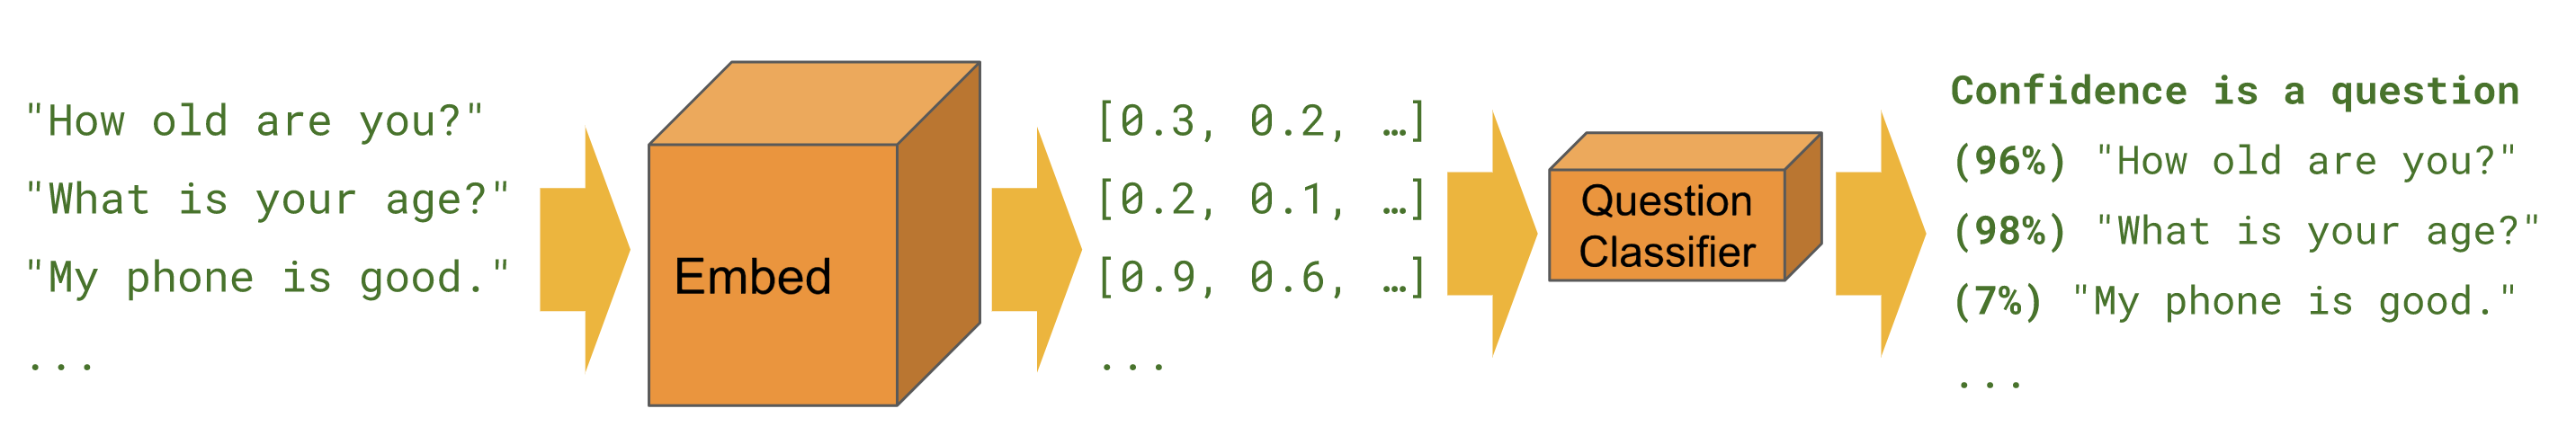

In [ ]:
import tensorflow_hub as hub

embeddings = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

embeddings

In [ ]:
embeddings(['Hello world']).shape

#### Embeddings são úteis para medir "similaridade semântica"

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Frases para comparação
frase1 = "Meu gato preto está dormindo na cadeira."
frase2 = "Meu felino escuro está descansando no assento."
frase3 = "My black cat is sleeping in the chair."

print(f"Frase 1: {frase1}")
print(f"Frase 2: {frase2}")
print(f"Frase 3: {frase3}")

# --- Similaridade com TF-IDF ---
print("\n--- Similaridade com TF-IDF ---")

# Transformar as frases usando o TF-IDF Vectorizer treinado anteriormente
# É importante que o TF-IDF Vectorizer tenha sido ajustado em um corpus maior
# para capturar melhor as relações das palavras. O vectorizer 'tfidf_vectorizer'
# foi ajustado nos dados de treino do dataset original.
tfidf_frase1 = tfidf_vectorizer.transform([frase1])
tfidf_frase2 = tfidf_vectorizer.transform([frase2])
tfidf_frase3 = tfidf_vectorizer.transform([frase3])

# Calcular a similaridade de cosseno entre os vetores TF-IDF
sim_tfidf_1_2 = cosine_similarity(tfidf_frase1, tfidf_frase2)[0][0]
sim_tfidf_1_3 = cosine_similarity(tfidf_frase1, tfidf_frase3)[0][0]
sim_tfidf_2_3 = cosine_similarity(tfidf_frase2, tfidf_frase3)[0][0]


print(f"Similaridade TF-IDF (Frase 1 vs Frase 2): {sim_tfidf_1_2:.4f}")
print(f"Similaridade TF-IDF (Frase 1 vs Frase 3): {sim_tfidf_1_3:.4f}")
print(f"Similaridade TF-IDF (Frase 2 vs Frase 3): {sim_tfidf_2_3:.4f}")

# --- Similaridade com Embeddings (Universal Sentence Encoder) ---
print("\n--- Similaridade com Embeddings (Universal Sentence Encoder) ---")

# Transformar as frases usando o modelo de embeddings
embeddings_frase1 = embeddings([frase1])
embeddings_frase2 = embeddings([frase2])
embeddings_frase3 = embeddings([frase3])


# Calcular a similaridade de cosseno entre os vetores de embeddings
sim_embeddings_1_2 = cosine_similarity(embeddings_frase1, embeddings_frase2)[0][0]
sim_embeddings_1_3 = cosine_similarity(embeddings_frase1, embeddings_frase3)[0][0]
sim_embeddings_2_3 = cosine_similarity(embeddings_frase2, embeddings_frase3)[0][0]

print(f"Similaridade Embeddings (Frase 1 vs Frase 2): {sim_embeddings_1_2:.4f}")
print(f"Similaridade Embeddings (Frase 1 vs Frase 3): {sim_embeddings_1_3:.4f}")
print(f"Similaridade Embeddings (Frase 2 vs Frase 3): {sim_embeddings_2_3:.4f}")

print("\n--- Análise ---")

#### Utilizando embeddings para treinar nosso classificador

In [ ]:
# Aplicar os embeddings nos dados de treino e teste
X_train_embeddings = embeddings(X_train)
X_test_embeddings = embeddings(X_test)

print("Formato dos embeddings de treino:", X_train_embeddings.shape)
print("Formato dos embeddings de teste:", X_test_embeddings.shape)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Inicializar o modelo Decision Tree
model_embedding = DecisionTreeClassifier()

# Treinar o modelo com os embeddings de treino e labels originais
model_embedding.fit(X_train_embeddings, y_train_encoded)

# Fazer previsões no conjunto de teste usando os embeddings de teste
predictions_embedding = model_embedding.predict(X_test_embeddings)

# Avaliar o modelo
print("Relatório de Classificação (Decision Tree com Embeddings):")
print(classification_report(y_test_encoded, predictions_embedding))

## 3 - Atividade de laboratório

Nesta tarefa, vocês aplicarão os conceitos de classificação de texto que exploramos neste notebook. O objetivo é classificar frases em diferentes categorias usando técnicas como TF-IDF e Embeddings.

O objetivo do laboratório será construir e avaliar um modelo de classificação capaz de prever a intenção de uma frase (confusão, certeza, ou afirmação neutra).

### Instruções

Sigam os passos abaixo, utilizando o código deste notebook como referência e adaptando-o quando necessário:

1.  **Carregar os Dados:**
    *   Utilize o código inicial do notebook para carregar os dados do arquivo `dados_confusão.txt`.
    *   Transforme os dados em um DataFrame pandas com as colunas 'text' e 'intent'.

2.  **Análise e Preparação dos Dados:**
    *   Verifiquem a distribuição das classes (`intent`) no dataset. Há desbalanceamento significativo?
    *   Dividam o dataset em conjuntos de treino e teste (por exemplo, 80% treino, 20% teste).

3.  **Classificação com TF-IDF e Decision Tree:**
    *   Apliquem o `TfidfVectorizer` nos dados de treino (`X_train`).
    *   Analisem as palavras com maior pontuação TF-IDF, como fizemos no notebook.
    *   Treinem um modelo `DecisionTreeClassifier` utilizando os dados de treino transformados pelo TF-IDF (`X_train_tfidf`) e os rótulos de treino (`y_train`).
    *   Transformem os dados de teste (`X_test`) usando o **mesmo** `TfidfVectorizer` treinado nos dados de treino.
    *   Façam previsões no conjunto de teste.
    *   Avaliem a performance do modelo no conjunto de teste usando o `classification_report`. Analisem as métricas (Precision, Recall, F1-score) e o que elas indicam sobre o desempenho do modelo em cada classe.

4.  **Classificação com Embeddings (Opcional - se o modelo de embeddings funcionar):**
    *   Apliquem-no nos dados de treino (`X_train`) e teste (`X_test`) para obter os vetores de embeddings.
    *   Treinem um modelo `DecisionTreeClassifier` (ou outro classificador de sua escolha, como `RandomForestClassifier` ou `MLPClassifier`) utilizando os embeddings de treino e os rótulos de treino.
    *   Façam previsões no conjunto de teste usando os embeddings de teste.
    *   Avaliem a performance do modelo e comparem com os resultados obtidos com TF-IDF.

5.  **Análise dos Resultados:**
    *   Comparem os relatórios de classificação dos modelos treinados (TF-IDF + Decision Tree e Embeddings + Classificador).
    *   Qual abordagem (TF-IDF vs. Embeddings) pareceu funcionar melhor para este dataset e **por quê**? Considerem o tamanho e a natureza dos dados.
    *   Quais classes o(s) modelo(s) tiveram mais dificuldade em classificar corretamente? O que isso pode indicar?

### Entrega

Até o final da semana, submetam o código completo da tarefa (em notebook) e **incluam células de texto no final do notebook (substituindo esta célula) para apresentar suas análises e respostas às perguntas do passo 5**.